In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.signal import butter, lfilter , filtfilt
import pandas as pd
import scipy as sp
import os
import sys
import seaborn as sb 
from matplotlib import cm

import pickle

# Section A

## Load the data

In [2]:
# Root folder for the data
data_folder = "/Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/data/raw_objects"
#Load the data
subject = 'MR012'
data_file = 'MR012_FM_aligned.mat'
data_file_path = os.path.join(data_folder,data_file)
verbose=0
data_key='data'
amplitudes_key='amplitudes'


In [3]:
root_data_matlab_struct = loadmat(data_file_path,struct_as_record=False,squeeze_me=True)
root_data_re_struct = loadmat(data_file_path)
# Because of the saving from Matlab there are arrays of size 1 containing the data
data_raw = root_data_re_struct[data_key][0][0]
# Not very pretty but it extracts the electrodes configuration names 
elec_names = root_data_re_struct[data_key].dtype.names
# As well as the recorded muscles names
muscle_and_other_names = data_raw[0][0][0].dtype.names

In [4]:
n_elec_configs = len(elec_names) #this is not the same as list_elecs! (since it has more configurations?)
n_muscles_and_other = len(muscle_and_other_names) #this is not the same as len(list_muscle_or_other_elec_i)

In [5]:
list_elec_config_dfs = []

for i_elec_config in range(n_elec_configs):       
    elec_config_i = elec_names[i_elec_config]
    if verbose: print(elec_config_i)
    elect_config_i_data = data_raw[elec_config_i][0,0] 
    list_muscle_and_other_elec_config_dfs = []
    list_amplitudes_elec_config=[]
    for i_muscle_and_other in range(n_muscles_and_other):
        muscle_and_other_i = muscle_and_other_names[i_muscle_and_other]
        if verbose: print(muscle_and_other_i)
        muscle_and_other_i_data = elect_config_i_data[muscle_and_other_i]
        n_trials_elec_muscle_and_other_i = np.shape(muscle_and_other_i_data)[-1]
        if verbose: print("N_trials",n_trials_elec_muscle_and_other_i)
        if muscle_and_other_i==amplitudes_key:
            # If it is the special case of amplitudes
            list_amplitudes_elec_config = muscle_and_other_i_data[0,:]      
        else:
            # Not amplitudes
            list_trial_muscle_and_other_elec_config_dfs = []
            for i_trial_elec_muscle_and_other in range(n_trials_elec_muscle_and_other_i):
                if verbose>1: print("trial",i_trial_elec_muscle_and_other)
                trial_muscle_and_other_i_data = muscle_and_other_i_data[0,i_trial_elec_muscle_and_other][0,:]
                n_time_points_trial = len(trial_muscle_and_other_i_data)
                df_trial_muscle_and_other_i_data = pd.DataFrame(data=[[trial_muscle_and_other_i_data]],columns=['Raw'])
                df_trial_muscle_and_other_i_data['Time_points'] = n_time_points_trial
                df_trial_muscle_and_other_i_data['Muscle_or_other'] = muscle_and_other_i
                df_trial_muscle_and_other_i_data['Elec_config'] = elec_config_i
                df_trial_muscle_and_other_i_data['Subject'] = subject
                list_trial_muscle_and_other_elec_config_dfs.append(df_trial_muscle_and_other_i_data)
            if len(list_trial_muscle_and_other_elec_config_dfs)>0:
                df_muscle_or_others = pd.concat(list_trial_muscle_and_other_elec_config_dfs, ignore_index=True)
                df_muscle_or_others.reset_index(inplace=True)
                df_muscle_or_others = df_muscle_or_others.rename(columns = {'index':'Trial_number'})
                list_muscle_and_other_elec_config_dfs.append(df_muscle_or_others)
    # Adds the amplitude to each trial
    n_muscles_and_other_elec_config_dfs = len(list_muscle_and_other_elec_config_dfs)
    for i_muscles_and_other_elec_config_df in range(n_muscles_and_other_elec_config_dfs):
        muscles_and_other_elec_config_df_i = list_muscle_and_other_elec_config_dfs[i_muscles_and_other_elec_config_df]
        muscles_and_other_elec_config_df_i['Amplitudes']=list_amplitudes_elec_config
        list_muscle_and_other_elec_config_dfs[i_muscles_and_other_elec_config_df] = muscles_and_other_elec_config_df_i
    if len(list_muscle_and_other_elec_config_dfs)>0:
        df_elec_config = pd.concat(list_muscle_and_other_elec_config_dfs, ignore_index=True)
        list_elec_config_dfs.append(df_elec_config)
if len(list_elec_config_dfs)>0:
    df_subject = pd.concat(list_elec_config_dfs, ignore_index=True)

In [6]:
# Only keeping the ones that got data
df_subject_no_empty = df_subject.where(df_subject['Time_points']>1)
df_subject_no_empty.dropna(inplace=True)

# Section B

## Set up object oriented data frame

In [7]:
#class to quicker acess the plots

#1. list of elec_muscle eg _1_6 each one will be one object (eg. same as when we graph the all the trials) 

list_elecs = df_subject_no_empty['Elec_config'].unique() #Elec01_, Elec02_, Elec03_, 
n_list_elecs = len(list_elecs) 
list_muscle_or_other_elec_i = df_subject_no_empty['Muscle_or_other'].unique() #LVlat, LST, ..
n_muscle_or_other_elec_i = len(list_muscle_or_other_elec_i)
list_elec_i_a_muslce_i=[]




class DfSubject:
    def __init__(self, elec_i, muscle_i):
        self.Elec_config=list_elecs[elec_i]
        self.List_elecs=list_elecs
        self.Muscle_or_other=list_muscle_or_other_elec_i[muscle_i]
        self.List_muscle_or_other=list_muscle_or_other_elec_i
        self.Trial_number= df_subject_no_empty[(df_subject_no_empty["Elec_config"]==self.Elec_config)& (df_subject_no_empty["Muscle_or_other"]== self.Muscle_or_other)]["Trial_number"]
        self.Trial_number=[int(i) for i in self.Trial_number] #save as int
        self.Raw= df_subject_no_empty[(df_subject_no_empty["Elec_config"]==self.Elec_config)& (df_subject_no_empty["Muscle_or_other"]== self.Muscle_or_other)]["Raw"]
        self.Raw.index=self.Trial_number
        
        self.Time_points= df_subject_no_empty[(df_subject_no_empty["Elec_config"]==self.Elec_config)& (df_subject_no_empty["Muscle_or_other"]== self.Muscle_or_other)]["Time_points"]
        self.Time_points.index=self.Trial_number
        self.Amplitudes= df_subject_no_empty[(df_subject_no_empty["Elec_config"]==self.Elec_config)& (df_subject_no_empty["Muscle_or_other"]== self.Muscle_or_other)]["Amplitudes"]
        self.Amplitudes.index=self.Trial_number
        self.TS_arts_1="$"
        
        # self.TS_arts_1.index=self.Trial_number
        self.Time_points_arts_1=-1
        self.TS_arts_2="$"
        self.Time_points_arts_2=-1
        self.TS_arts_3="$"
        self.Time_points_arts_3=-1


#4. Goal is to chose an electrode and a muscle and see all the trials and the corrected data        
#       eg. pData["_3_5"].Raw[19] #prints the raw data from trial 19

In [8]:
#Run the class for all electrodes and muscles and save it in pData as elec_muscle eg _0_0

pData = {}
for elec_i in range(n_list_elecs):
    for muscle_i in range(n_muscle_or_other_elec_i):
        pData[f"_{elec_i}_{muscle_i}"] = DfSubject(elec_i, muscle_i)

## Save the data as a pickle file

In [9]:
### save files as pickle file  to projectome_finder#
#to run set run=1
run=1
if run == 1:
    import pickle
    fh = open('/Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/Class2_dump.pkl', "wb")
    pickle.dump(pData, fh)
    fh.close()

## Retrieve the data from pickle 

In [10]:
### retrieve  dfSubject structured as pData  #
#run the structure of the data before opening the pickle (wihtout creating an object)
# command pData["_0_"].Trial_number=0
import pickle
run=0
if run == 1:  

    with open('Class2_Dump.pkl', 'rb') as handle:
        pData = pickle.load(handle)


# Working on how to extract individual object and dont' have to load all the objects

In [11]:
#Idea from stackoverflow


import pickle

file = open('test.pkl','wb')
obj_1 = ['test_1', {'ability', 'mobility'}]
obj_2 = ['test_2', {'ability', 'mobility'}]
obj_3 = ['test_3', {'ability', 'mobility'}]

pickle.dump(obj_1, file)
pickle.dump(obj_2, file)
pickle.dump(obj_3, file)

file.close()

file = open('test.pkl', 'rb')
obj_1 = pickle.load(file)
obj_2 = pickle.load(file)
obj_3 = pickle.load(file)
# print(obj_1)
# print(obj_2)
print(obj_3)
file.close()

['test_3', {'ability', 'mobility'}]


tried to implement code above, but not working with for loop yet

In [12]:
# #### Load data ####
# import pickle
# fh = open('/Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/data/pickle_files/Class2_dump.pkl', "wb")
# for objects in pData:
#     pickle.dump(objects, fh)
#     print(objects)
    
# fh.close()

# #### Retrieve data ###
# import pickle

# fh=open('Class2_Dump.pkl', 'rb')
# _0_0=pickle.load(fh)
# _0_1=pickle.load(fh)

Plot to compare with the tensor plot

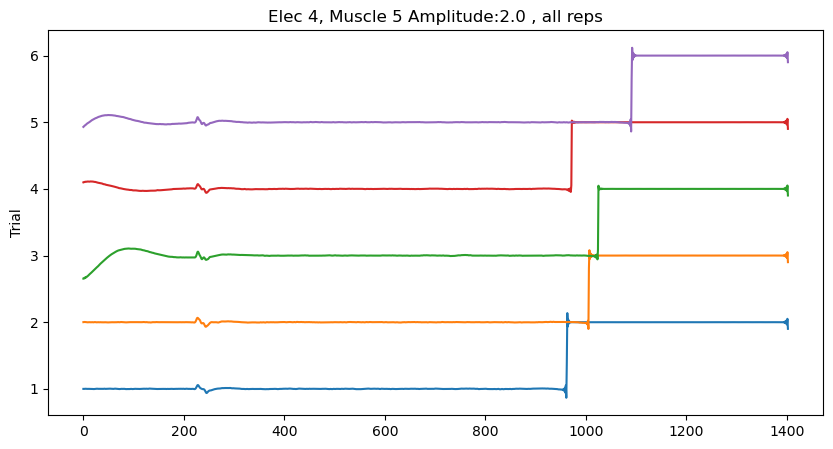

In [38]:
### extract on ly data with spec ele

elec_i = list_elecs[4]
df_subject_no_empty_elec_i = df_subject_no_empty.where(df_subject_no_empty['Elec_config']==elec_i)
df_subject_no_empty_elec_i.dropna(inplace=True)

### extract only data with elec 4 and muscle 5
list_muscle_or_other_elec_i = df_subject_no_empty_elec_i['Muscle_or_other'].unique()
muscle_i_elec_i = list_muscle_or_other_elec_i[5]
df_subject_no_empty_elec_i_muscle_i = df_subject_no_empty_elec_i.where(df_subject_no_empty_elec_i['Muscle_or_other']==muscle_i_elec_i)
df_subject_no_empty_elec_i_muscle_i.dropna(inplace=True)

### extract only data with elec 4 muscle 5 and amp=2
df_subject_no_empty_elec_i_muscle_i_amp_i=df_subject_no_empty_elec_i_muscle_i.where(df_subject_no_empty_elec_i_muscle_i['Amplitudes']==2.0)
df_subject_no_empty_elec_i_muscle_i_amp_i.dropna(inplace=True)

offset=0 #in order to not have all the trials overlapping
plt.figure(figsize = (10,5))
i=5625 
for j in range (5):
    offset+=1
    plt.plot(df_subject_no_empty_elec_i_muscle_i_amp_i["Raw"][i]+offset, label=f" reps {j}")
    i+=1
    plt.ylabel("Trial")
    plt.title(f"Elec 4, Muscle 5 Amplitude:2.0 , all reps")
plt.show()